# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

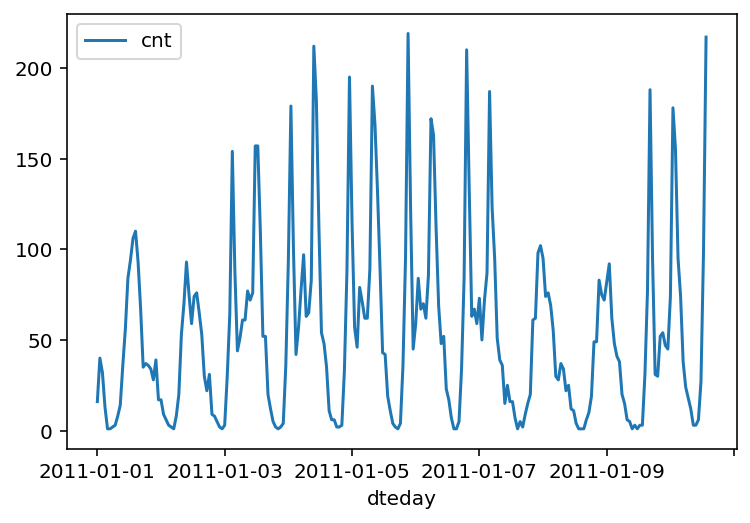

In [7]:
rides[:24*10].plot(x='dteday', y='cnt');

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [8]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [9]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [10]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [11]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure. You'll implement both the forward pass and backwards pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [12]:
#############
# In the my_answers.py file, fill out the TODO sections as specified
#############

from my_answers import NeuralNetwork

In [13]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [14]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.004s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, this process can have sharply diminishing returns and can waste computational resources if you use too many iterations.  You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. The ideal number of iterations would be a level that stops shortly after the validation loss is no longer decreasing.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. Normally a good choice to start at is 0.1; however, if you effectively divide the learning rate by n_records, try starting out with a learning rate of 1. In either case, if the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
In a model where all the weights are optimized, the more hidden nodes you have, the more accurate the predictions of the model will be.  (A fully optimized model could have weights of zero, after all.) However, the more hidden nodes you have, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.  

Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.  You'll generally find that the best number of hidden nodes to use ends up being between the number of input and output nodes.

In [313]:
log_file_name = "training_logs/training_log.txt"
def log_training_results(iterations, learning_rate, hidden_nodes,
                        train_loss, val_loss, min_loss, min_loss_iteration):
    with open(log_file_name, "a") as log_file:
            result = "PASS" if val_loss <= 0.18 else "FAIL"
            log_file.write(f"============= {result} =============\n")
            log_file.write(f"IT: {iterations} | LR: {learning_rate} | HL: {hidden_nodes}\n")
            log_file.write(f"Train loss: {train_loss}\nValidate loss: {val_loss}\n")
            log_file.write(f"Minimum validation loss: {min_loss} at iteration {min_loss_iteration}\n\n") 

In [273]:
import sys
from my_answers import iterations, learning_rate, hidden_nodes, output_nodes

def run_training_session(iterations, hidden_nodes, learning_rate, output_nodes, print_progress):
    N_i = train_features.shape[1]
    network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

    min_loss = 1000
    min_loss_iteration = -1

    losses = {'train':[], 'validation':[]}
    for ii in range(iterations):
        # Go through a random batch of 128 records from the training data set
        batch = np.random.choice(train_features.index, size=128)
        X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']

        network.train(X, y)

        # Printing out the training progress
        train_loss = MSE(network.run(train_features.values).T, train_targets['cnt'].values)
        val_loss = MSE(network.run(val_features.values).T, val_targets['cnt'].values)
        if (print_progress):
            sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                             + "% ... Training loss: " + str(train_loss)[:5] \
                             + " ... Validation loss: " + str(val_loss)[:5])
            sys.stdout.flush()

        if train_loss < 2 and val_loss < 2:
            losses['train'].append(train_loss)
            losses['validation'].append(val_loss)

        if val_loss < min_loss * 0.95:
            min_loss = val_loss
            min_loss_iteration = ii

    log_training_results(iterations, learning_rate, hidden_nodes, train_loss, val_loss, min_loss, min_loss_iteration)
    return network, losses

network, losses = run_training_session(iterations, hidden_nodes, learning_rate, output_nodes, True)

Progress: 100.0% ... Training loss: 0.061 ... Validation loss: 0.125

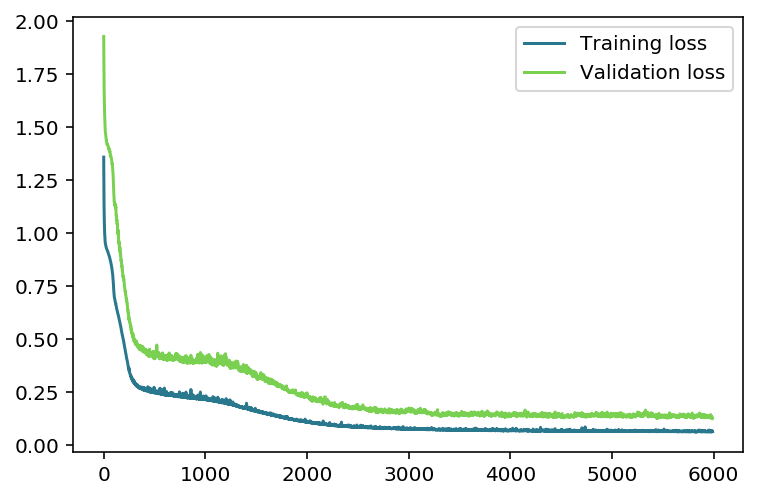

In [274]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

> _Custom code starts here._

# Finding the Optimal Hyperparameters
### Custom Solution by Mateusz Rogalski

The final objective of the project was to find a set of hyperparameters that, when used to train the implemented neural network, result in good prediction accuracy for the network.

Trying to find the best training parameters by simply setting them by hand and seeing what happens can work. However, it also introduces the unwelcome factor of luck and most likely won't result in optimal values. That’s why I decided to go a bit deeper into this problem. I wanted to create a data set representing the relationships between the hyperparameters and the network’s performance during training.

To accomplish that, I wrote two extra classes for the project: HyperparameterGenerator and LogParser. The former is used to generate a range of hyperparam values, while the latter reads a text file containing training logs and converts it into a Pandas DataFrame.

Armed with these tools I modified the project’s Jupyter notebook to implement looped network training. The loop automatically starts a new training session for each of the parameter sets provided by HyperparameterGenerator. Results of each session, including the final validation loss are recorded in a log file.
Then, after almost 700 training sessions I begun analysing the collected data. I made further modifications to the notebook to display various plots visualizing the data. The results are below.

In [276]:
from hyperparam_generator import HyperparameterGenerator
from hyperparam_generator import ParamRange

hidden_node_count_range = ParamRange(44, 44, 1)
learning_rate_range = ParamRange(0.3, 0.4, 0.01)
iterations_range = ParamRange(1000, 9000, 4000)

def run_training_using_hyperparam_generator():
    generator = HyperparameterGenerator(iterations_range, hidden_node_count_range, learning_rate_range)
    for params in generator.get_parameters():
        iterations = params["iterations"]
        hidden_nodes = params["hidden nodes"]
        learning_rate = params["learning rate"]
        output_nodes = 1
        run_training_session(iterations, hidden_nodes, learning_rate, output_nodes, print_progress=False)

# The commented line below runs the training loop. I disabled it to prevent accidental activation.
#run_training_using_hyperparam_generator()

In [312]:
from pathlib import Path

from log_parser import LogParser


def load_training_log_data(log_file) -> pd.DataFrame:
    parser = LogParser()
    log_data = parser.parse(Path(log_file))
    log_data = log_data.dropna()
    log_data["loss difference"] = log_data["validation loss"] - log_data["training loss"]
    log_data.reset_index()
    return log_data


log_data = load_training_log_data("training_logs/log_combined.txt")
tested_node_counts = log_data["hidden nodes"].unique()
tested_node_counts.sort()

print(f"Loaded data from {len(log_data)} network training sessions.")
log_data.describe()

Loaded data from 667 network training sessions.


,iterations,hidden nodes,learning rate,training loss,validation loss,loss difference
count,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000
mean,5805.097451,32.677661,0.507234,0.206454,0.349871,0.143417
std,1235.038187,14.225854,0.217904,0.240082,0.337700,0.110458
min,1000.000000,4.000000,0.100000,0.049721,0.120575,0.004210
25%,5600.000000,20.000000,0.340000,0.064564,0.153611,0.085304
50%,6000.000000,36.000000,0.500000,0.081699,0.182184,0.099005
75%,6000.000000,44.000000,0.650000,0.215336,0.389901,0.145438
max,10000.000000,56.000000,1.000000,0.981871,1.394589,0.543824


In [303]:
import cycler
import matplotlib


def get_point_size(iterations):
    return (iterations/400)**1.8


def create_scatter_plot(axes, node_count, all_data, y_column):
    data_block = all_data[all_data["hidden nodes"] == node_count].sort_values(by="learning rate")
    axes.scatter(data=data_block, x="learning rate", y=y_column, 
                 s=get_point_size(data_block["iterations"]),
                 label=f"{node_count}")
    

def node_count_lr_plot(ax, node_count, iterations=None):
    plot_data = log_data[log_data["hidden nodes"] == node_count].sort_values("learning rate")
    if iterations:
        plot_data = plot_data[plot_data["iterations"] == iterations]
    plot_data = plot_data.groupby("learning rate").mean().reset_index()
    ax.plot(plot_data["learning rate"], plot_data["validation loss"], linewidth=3)
    
    
def node_count_it_plot(ax, node_count, learn_rate):
    plot_data = log_data[log_data["hidden nodes"] == node_count].sort_values("iterations")
    plot_data = plot_data[plot_data["learning rate"] == learn_rate]
    plot_data = plot_data.groupby("iterations").mean().reset_index()
    ax.plot(plot_data["iterations"], plot_data["validation loss"], linewidth=3)
    
    
def setup_color_cycling():
    color_count = len(tested_node_counts)
    color = plt.cm.viridis(np.linspace(0, 1, color_count))
    matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)



def plot_final_validation_loss_vs_hidden_count():
    setup_color_cycling()
    fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(15,8))
    for node_count in tested_node_counts:
        create_scatter_plot(ax, node_count, log_data, "validation loss")
    ax.plot([0, 1.6], [0.18, 0.18], linewidth=1, color="black", linestyle=':')
    ax.legend(title="Hidden Nodes", fancybox=False, shadow=True, loc='center left', bbox_to_anchor=(1, 0.51))
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("Validation Loss")
    ax.set_title("Hyperparameter Impact on Final Validation Loss\n(dot size proportional to iteration count)")
    ax.set_ylim((0,0.5))
    ax.set_xlim((0,1.20))
    ax.annotate("validation loss = 0.18", (1.03,0.185));
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
    
    
def plot_final_validation_loss_vs_hidden_count_zoomed():
    fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(15,5))
    for node_count in tested_node_counts:
        create_scatter_plot(ax, node_count, log_data, "validation loss")
    ax.plot([0, 1.6], [0.18, 0.18], linewidth=1, color="black", linestyle=':')
    ax.legend(title="Hidden Nodes", fancybox=False, shadow=True, loc='center left', bbox_to_anchor=(1, 0.59), ncol=2)
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("Validation Loss")
    ax.set_title("Hyperparameter Impact on Validation Loss - Zoomed")
    ax.set_ylim((0.11,0.2))
    ax.set_xlim((0.15,1.10))
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
    ax.locator_params(nbins=36, axis='x')
    ax.locator_params(nbins=10, axis='y')
    ax.grid(True, alpha=0.2)
    
    
def plot_final_validation_loss_vs_hidden_count_grouped():
    node_count_batches = [log_data[(log_data["hidden nodes"] > x*16) & (log_data["hidden nodes"] <= (x+1)*16)] for x in range(0, 4)]

    color = plt.cm.viridis(np.linspace(0, 1, len(node_count_batches)))
    matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

    fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(15,8))

    for data_batch in node_count_batches:
        ax.scatter(data=data_batch, x="learning rate", y="validation loss", 
                   s=get_point_size(data_batch["iterations"]))

    legend_labels = ["0 to 16", "16 to 32", "32 to 48", "48 to 56"]
    ax.legend(labels=legend_labels, title="Hidden Nodes", fancybox=False, shadow=True, loc='center left', bbox_to_anchor=(1, 0.905))
    ax.plot([0, 1.6], [0.18, 0.18], linewidth=1, color="black", linestyle=':')
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("Validation Loss")
    ax.set_title("Hyperparameter Impact on Validation Loss - Node Count Groups")
    ax.set_ylim((0,0.5))
    ax.set_xlim((0,1.20))
    ax.annotate("validation loss = 0.18", (1.03,0.185));
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
    

def plot_avg_validation_loss_vs_learn_rate_selected_linear():
    color = plt.cm.viridis([0.4, 0.8, 0.99])
    matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

    fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(15,8))
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("Averaged Validation Loss")
    ax.set_title(f"Averaged Validation Loss at 6000 Iterations")
    ax.set_ylim((0.1,0.6))
    ax.set_xlim((0,1.20))

    best_counts = [8, 20, 44]

    for node_count in best_counts:
        node_count_lr_plot(ax, node_count, 6000)

    ax.legend(labels=best_counts, title="Hidden Nodes", fancybox=False, shadow=True)
    ax.plot([0, 1.6], [0.18, 0.18], linewidth=1, color="black", linestyle=':')
    
    
def plot_avg_validation_loss_vs_iterations_linear():
    fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(15,10))
    ax.set_xlabel("Training Iterations")
    ax.set_ylabel("Averaged Validation Loss")
    ax.set_title(f"Averaged Validation Loss at Best Learning Rate")
    ax.set_ylim((0.1,0.5))
    ax.set_xlim((0,10000))

    learn_rates = {8:0.7, 20:0.65, 44:0.35}
    labels = []

    for node_count in learn_rates.keys():
        node_count_it_plot(ax, node_count, learn_rates[node_count])
        labels.append(f"{'  ' if node_count == 8 else ''}{node_count} | {learn_rates[node_count]}")

    ax.legend(labels=labels, title="Nodes | LR", fancybox=False, shadow=True)
    ax.plot([0, 10000], [0.18, 0.18], linewidth=1, color="black", linestyle=':')
    ax.locator_params(nbins=10, axis='x')
    
    
def print_best_validation_loss_results(top_count):
    best_vl_results = log_data.sort_values(["validation loss", "loss difference"]).head(top_count)
    
    print("Top result")
    print("------------------------------")
    print(best_vl_results.iloc[0])

    print(f"\nLowest node count in top {top_count}")
    print("------------------------------")
    print(log_data.loc[best_vl_results["hidden nodes"].idxmin()])

    print(f"\nHighest node count in top {top_count}")
    print("------------------------------")
    print(log_data.loc[best_vl_results["hidden nodes"].idxmax()])

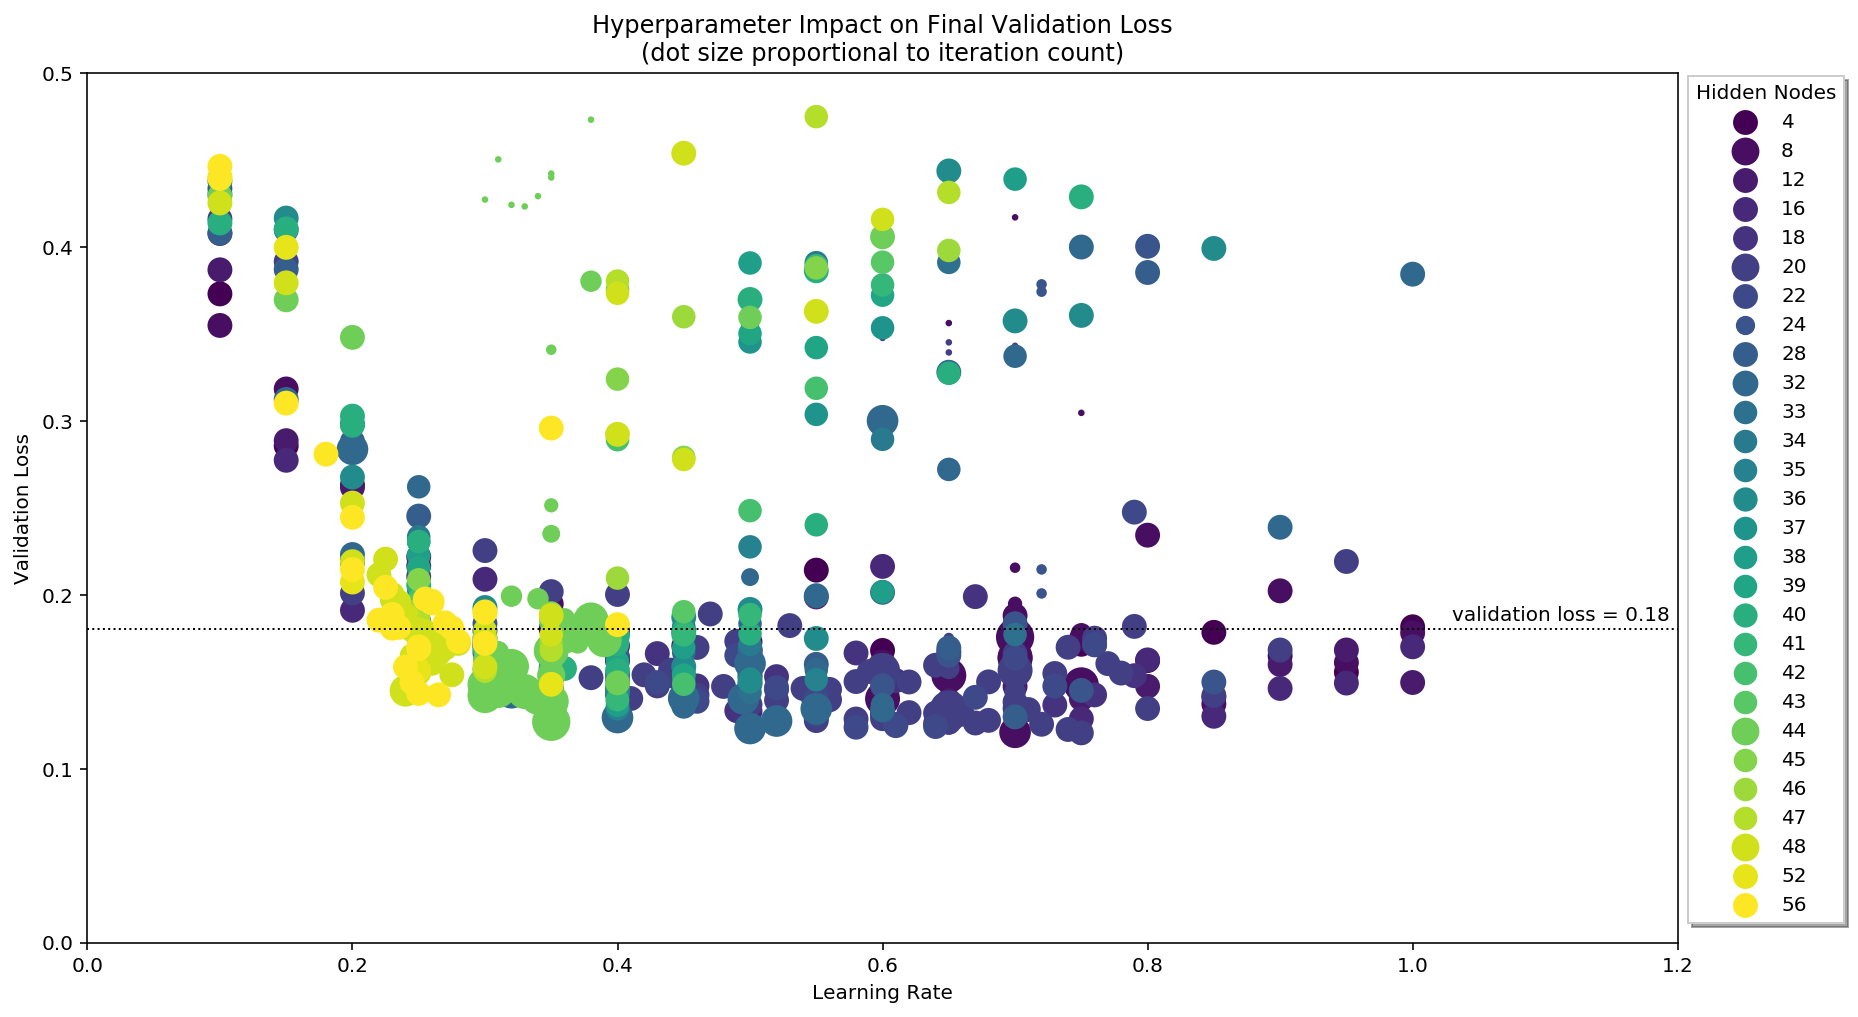

In [279]:
plot_final_validation_loss_vs_hidden_count()

In [307]:
print_best_validation_loss_results(top_count=16)

Top result
------------------------------
iterations         6000.000000
hidden nodes         20.000000
learning rate         0.750000
training loss         0.055128
validation loss       0.120575
loss difference       0.065447
Name: 227, dtype: float64

Lowest node count in top 16
------------------------------
iterations         8000.000000
hidden nodes          8.000000
learning rate         0.700000
training loss         0.057671
validation loss       0.120898
loss difference       0.063226
Name: 655, dtype: float64

Highest node count in top 16
------------------------------
iterations         10000.000000
hidden nodes          44.000000
learning rate          0.350000
training loss          0.058068
validation loss        0.126918
loss difference        0.068850
Name: 667, dtype: float64


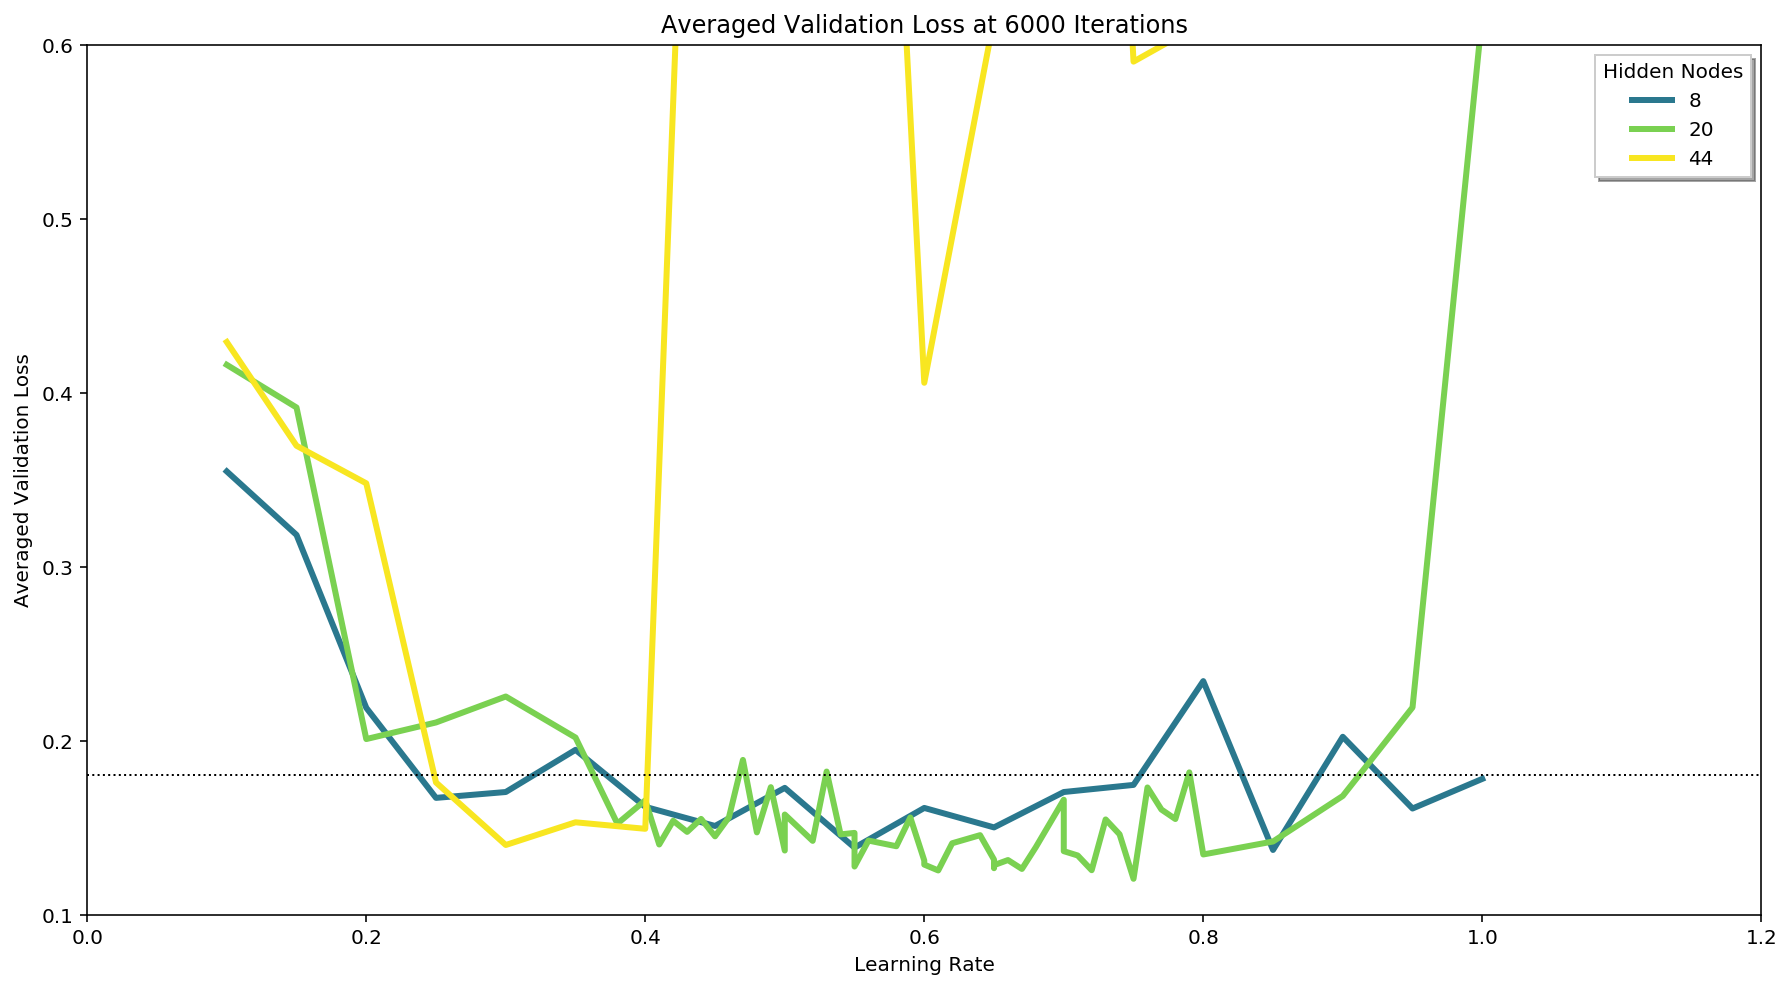

In [280]:
plot_avg_validation_loss_vs_learn_rate_selected_linear()

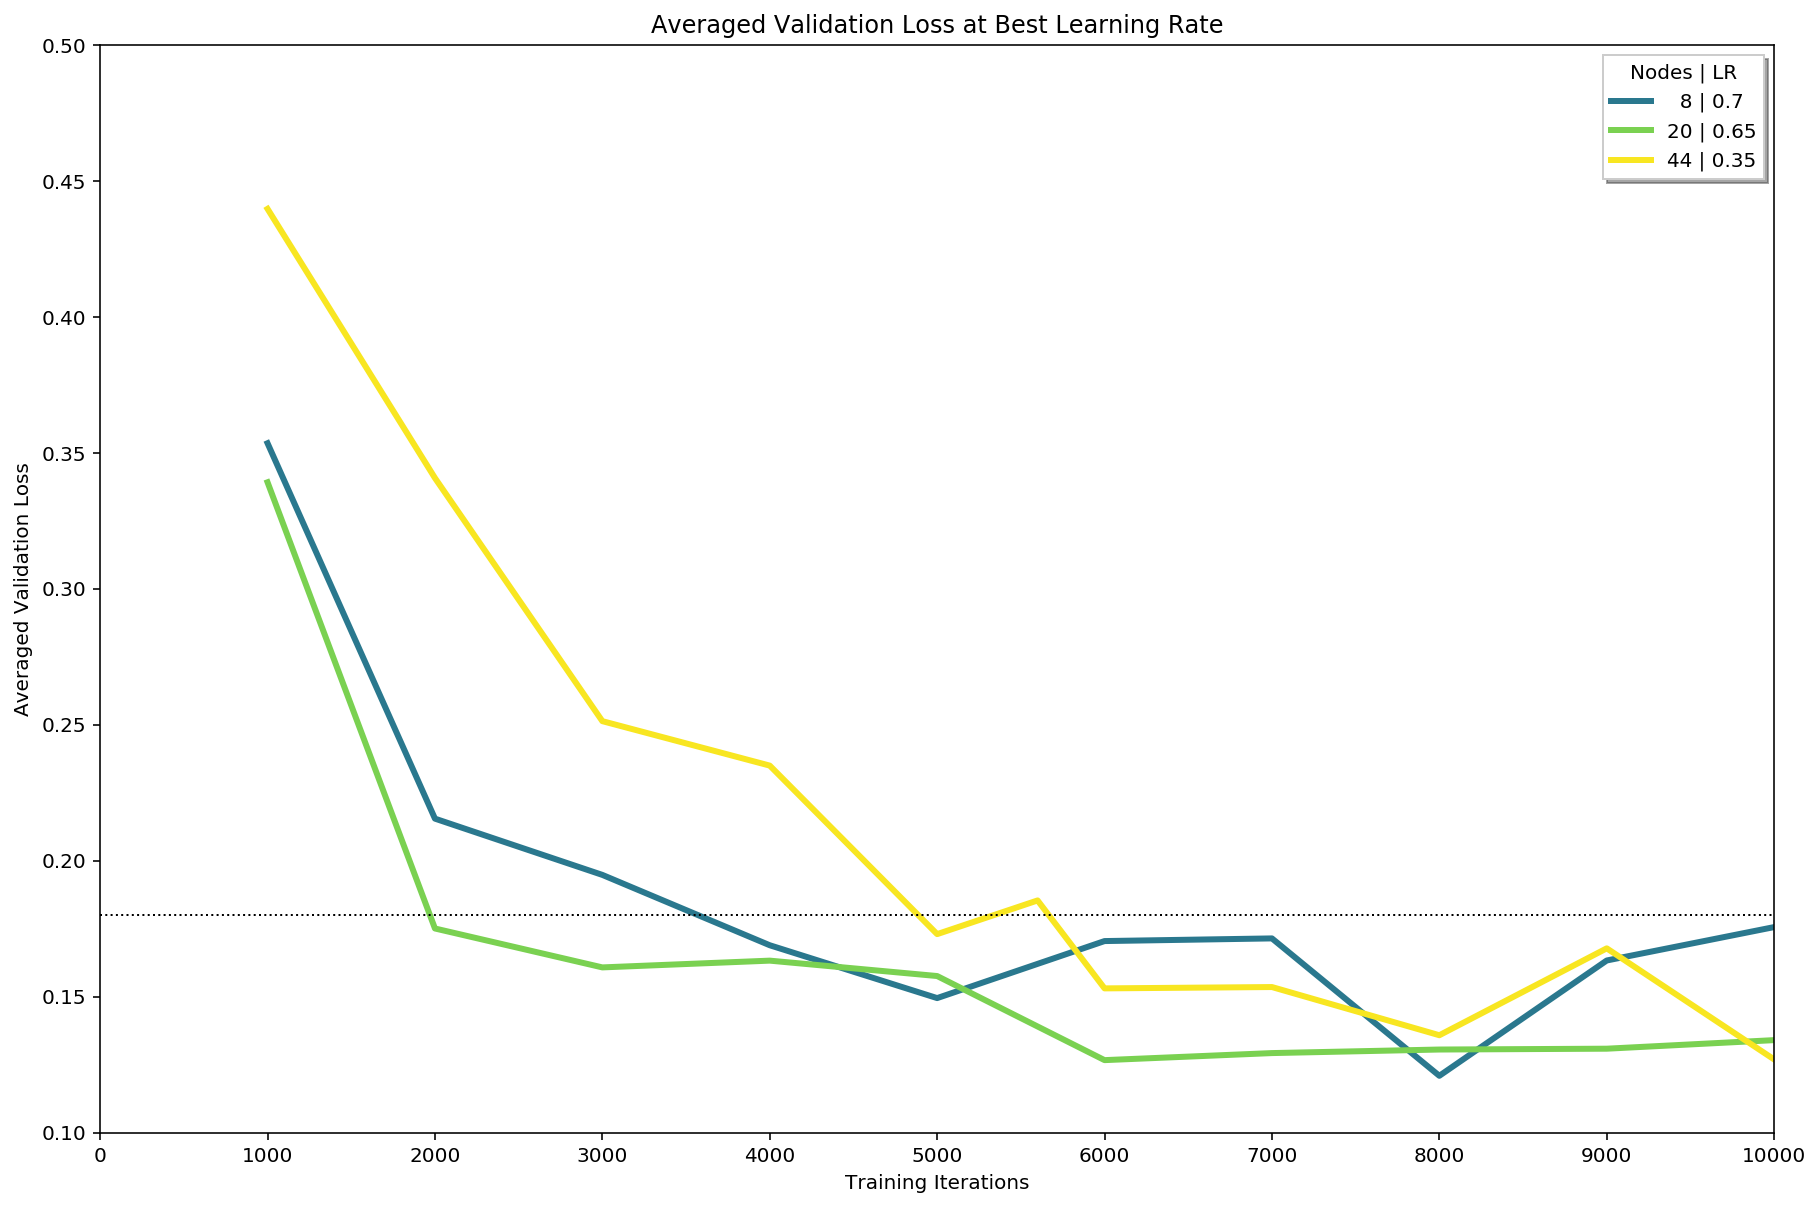

In [281]:
plot_avg_validation_loss_vs_iterations_linear()

# Training Data Analysis

Looking at the produced data and its visualizations we can come to the following conclusions.

- Most training sessions resulted with the network reaching the acceptably small validation loss, i.e. under 0.18.
- The more hidden neurons are used, the smaller the learning rate needs to be to reach good accuracy. This is most likely caused by how the output error is calculated, resulting in greater magnitudes of individual node errors in backpropagation as their count increases. Setting a smaller learning rate counteracts this increase.
- Even small counts of hidden neurons were enough to reach satisfying results. The lowest count in the top 16 results collected was 8, and from the diagrams we see that even 4 hidden neurons can be enough, given the right learning rate. Therefore, if training speed is the primary concern, hidden node count should be set low (4) and learning rate set high (1.0).
- High hidden node counts require low learning rate and a large number of training iterations to reach good accuracy. Even then, the network’s performance isn’t better than for lower node counts. This makes using more than 30-40 hidden nodes not practical for this network architecture.
- 6000 training iterations seems to be the optimal count for maximizing accuracy. After that, the network seems to begin overfitting as the validation loss starts to increase or fluctuate.
- In conclusion, it turned out that 20 hidden nodes with 6000 training iterations and a learning rate of 0.7 provide the best network accuracy within the explored parameter space.


> _End of custom code._

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

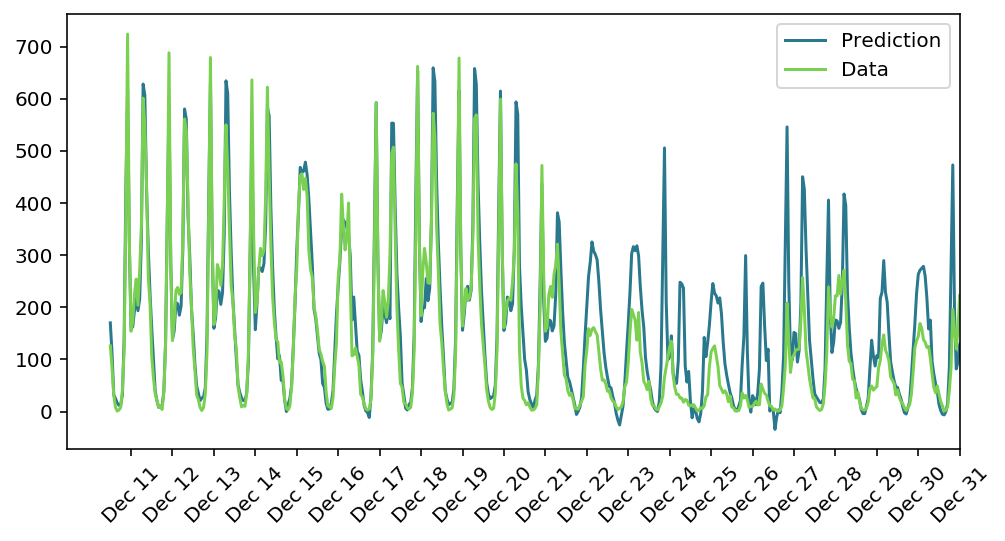

In [308]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features.values).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below
The model predicts the data very well for the first 10 days. It recreated the usual double peaks during rush hours on weekdays and the more unimodal distribution on weekends.

However, starting from December 22, the predictions are not accurate. They seem to still follow the previous pattern, but the actual data doesn’t. A likely cause could be some special event that altered the customers’ behaviour on these days.  And indeed, the time of the pattern change coincides with the beginning of Christmas. During holidays many people don’t commute to work, which most likely has a significant impact on the amount of bike rentals.

To fix this problem the network would need to be trained on a bigger dataset (spanning several years) so that it can learn the seasonal changes of rental patterns caused by the various holidays.


## Submitting:
Open up the 'jwt' file in the first-neural-network directory (which also contains this notebook) for submission instructions